In [2]:
# === Essential Imports ===
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix

# === Dataset Path (REAL ONLY) ===
REAL_DATA_DIR = './dataset_2'  # Updated path to point to original dataset

# === Settings ===
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 4
AUTOTUNE = tf.data.AUTOTUNE
SEED = 123


In [3]:
# === Load Dataset with 80/20 Train/Val Split ===
raw_train_ds = image_dataset_from_directory(
    REAL_DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

raw_val_ds = image_dataset_from_directory(
    REAL_DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

# ✅ Extract class names before preprocessing
class_names = raw_train_ds.class_names
print("✅ Classes:", class_names)

# === Preprocess datasets
def preprocess_dataset(ds):
    return ds.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

train_ds = preprocess_dataset(raw_train_ds)
val_ds = preprocess_dataset(raw_val_ds)

# === Confirm batch sizes
print("✅ Training batches:", train_ds.cardinality().numpy())
print("✅ Validation batches:", val_ds.cardinality().numpy())


Found 480 files belonging to 4 classes.


Using 384 files for training.
Found 480 files belonging to 4 classes.
Using 96 files for validation.
✅ Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
✅ Training batches: 12
✅ Validation batches: 3


In [4]:
# === Build EfficientNetB0 Model ===
base_model = EfficientNetB0(
    include_top=False,
    input_shape=IMG_SIZE + (3,),
    weights='imagenet'
)
base_model.trainable = False  # Freeze base model for feature extraction

# === Add classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

# === Final model
model = Model(inputs=base_model.input, outputs=output)

# === Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [5]:
# === Callbacks ===
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# === Train the model ===
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stop]
)


Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 619ms/step - accuracy: 0.2365 - loss: 1.6835 - val_accuracy: 0.2188 - val_loss: 1.5991
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 414ms/step - accuracy: 0.2072 - loss: 1.6733 - val_accuracy: 0.2500 - val_loss: 1.5133
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 441ms/step - accuracy: 0.2996 - loss: 1.5278 - val_accuracy: 0.2917 - val_loss: 1.4457
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 440ms/step - accuracy: 0.1747 - loss: 1.5614 - val_accuracy: 0.3542 - val_loss: 1.3890
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 428ms/step - accuracy: 0.2922 - loss: 1.4599 - val_accuracy: 0.4167 - val_loss: 1.3396
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 442ms/step - accuracy: 0.3384 - loss: 1.4161 - val_accuracy: 0.4271 - val_loss: 1.2930
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 478ms/step - accuracy: 0.3219 - loss: 1.3632 - val_accuracy: 0.4896 - val_loss: 1.2515
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 904ms/step - accuracy: 0.3528 - loss: 1.3389 - val_accuracy: 

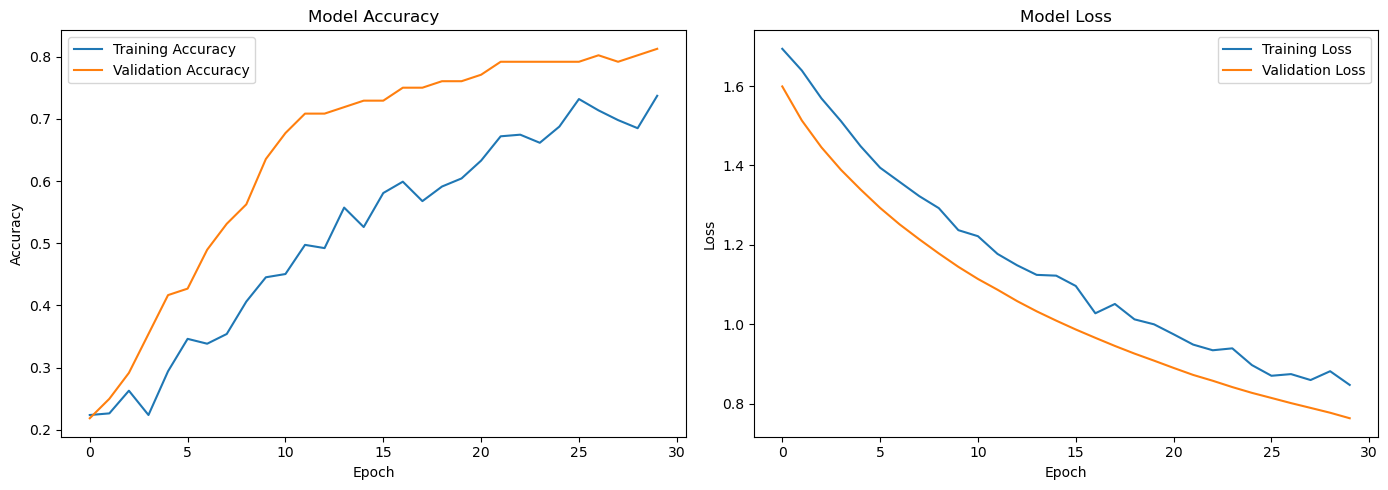

In [6]:
# === Plot training history ===
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [7]:
# === Load and preprocess test dataset
TEST_DIR = './test'

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",  # Matches training config
    color_mode="rgb",
    shuffle=False
)

test_ds = test_ds.map(
    lambda x, y: (preprocess_input(x), y),
    num_parallel_calls=AUTOTUNE
).prefetch(AUTOTUNE)


Found 480 files belonging to 4 classes.


15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 720ms/step
✅ Classification Report:
              precision    recall  f1-score   support

      glioma       0.78      0.80      0.79       120
  meningioma       0.62      0.48      0.54       120
     notumor       0.79      0.82      0.81       120
   pituitary       0.77      0.88      0.82       120

    accuracy                           0.75       480
   macro avg       0.74      0.75      0.74       480
weighted avg       0.74      0.75      0.74       480


📊 Confusion Matrix Table:


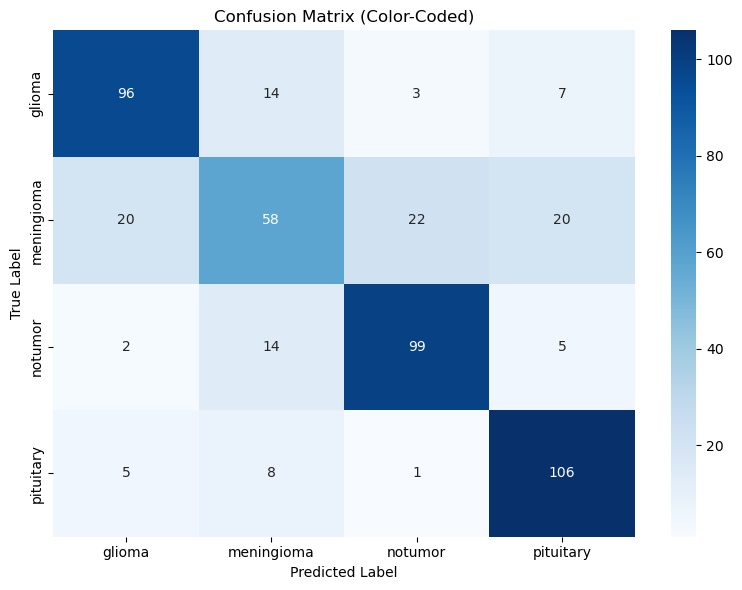

In [8]:
# === Predict and Evaluate
y_true = np.concatenate([y.numpy() for x, y in test_ds])
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_true, axis=1)

# === Classification Report
print("✅ Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# === Confusion Matrix Table
from sklearn.metrics import confusion_matrix
import pandas as pd

cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
print("\n📊 Confusion Matrix Table:")

# === Confusion Matrix Heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title('Confusion Matrix (Color-Coded)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()


In [9]:
# Save as a single .h5 file
model.save("efficientnet_base.h5")
print("✅ Model saved as efficientnet_base.h5")


✅ Model saved as efficientnet_base.h5
